# Week 1
### Large Cap US Stock Analysis
NVDA- NVIDIA
MS- Morgan Stanley
BX-  Blackstone
JPM- JP Morgan
GE- General Electric Aerospace

Importing 
### Note:
define tickers here and store their csv file in data folder in the same directory as this notebook

In [1]:
#tickers = ["NVDA", "MS", "BX", "JPM", "GE"]
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "GOOGL"]


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

#### Function to clear up and missing info 
- uses interpolation to fill most data, then forward fill and backward fill for edge cases at top edge and bottom edge, if data is reliable, we can add argument (limit=1) for ffill and bfill, but if not, then then omitting it helps take care of block of missing value at top and bottom edge.

In [2]:
def cleanDF(df):
    df.interpolate(method="linear", inplace=True, limit_direction="both")

    #for edge cases
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

#### Function to filter the dataframe to a certain set of period of years from the last available data's date

In [3]:
def filterYearPeriod(df, years):
    #since the data is only recorded to around 2017, taking last data's date as the end of of our period
    #Note: the date needs to be in datetime format
    lastDate = df['Date'].max()

    #defining a cutoff date for time, years can be changed according to will
    noOfYears=years
    cutoffDate = lastDate -  pd.DateOffset(years = noOfYears)

    df = df[df['Date'] >= cutoffDate]
    return df
    

#### Function to find the technical indicators for df and add them as columns:
- Daily Return: % change in closing price
- 7-day Moving Average of closing price
- 30-day Moving Average of closing price
- Rolling Volatility (30d): Standard deviation of returns over the last 30 days

In [4]:
def addTechnicalIndicators(df):
    #daily return (%)
    df['Daily Return (%)'] = df['Close'].pct_change()*100
    #using min_periods=1 to allow row 2 and onwards to have data. row 1 for daily return and std deviation cannot have data as no preceding data to work on for ma it can still just use current closing value
    #7 day moving average
    df['7-Day Moving Average'] = df['Close'].rolling(window=7, min_periods=1).mean()
    #30 day moving average
    df['30-Day Moving Average'] = df['Close'].rolling(window=30, min_periods=1).mean()
    #rolling volatility over 30 days
    df['Rolling Volatility (30d)'] =  df['Close'].rolling(window=30, min_periods=1).std()
    return df
    

##### Importing Data and Loading to MultiIndexed DataFrames
- with Ticker and Date as Indices
- Converting Date to datetime format
- Then cleaning up to fill missed values using interpolation or forward fill 

In [5]:
dataFrames = {}
period=10

for ticker in tickers:
    dataFrame = pd.read_csv(f'data/{ticker.lower()}.us.txt')
    #converting date to datetime format
    dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
    #sorting on basis of date
    dataFrame.sort_values('Date', inplace=True)
    #filtering last 10 years data
    dataFrame = filterYearPeriod(dataFrame, period)

    #filling missing values
    dataFrame = cleanDF(dataFrame)
    #adding ticker column
    dataFrame['Ticker'] = ticker
    dataFrame.set_index(['Ticker', 'Date'], inplace=True)
    dataFrame = addTechnicalIndicators(dataFrame)
    
    dataFrames[ticker]= dataFrame
    



#### Functions to compute average daily return and mean rolling volatility

In [6]:
def avgReturn(df):
    return df['Daily Return (%)'].mean()
def meanMonthlyRollingVolatility(df):
    #creating a deep copy to not change original file
    sudodf = df.copy(deep=True)
    #adds another column with datetime only accurate to the month to help get monthly rolling volatility
    sudodf['Year-Month'] =  sudodf.index.get_level_values('Date').to_period('M')
    #df of monthtly volatility
    monthlyVolatility = sudodf.groupby(['Year-Month'])['Rolling Volatility (30d)'].mean()

    #now finding most volatile month and volatility in that month
    month = monthlyVolatility.idxmax()
    volatility = monthlyVolatility.max()

    return [monthlyVolatility, month, volatility]
    
    
    

- Now we use these functions to get average daily return and volatility and format and print the information for each of them

In [7]:
avgReturns=[]
greatestMonthlyAvgVolatility=[]
correspondingMonths=[]
for i,dataFrame in enumerate(dataFrames.values()):
    avgRet=avgReturn(dataFrame)
    print(f"{tickers[i]} had a average daily return of {avgRet}% over the last 10 years of data.")
    avgReturns.append(avgRet)
    
    vol = meanMonthlyRollingVolatility(dataFrame)
    print(f"{tickers[i]} had the most volatile month - {vol[1]} with a average volatility of {vol[2]}")
    greatestMonthlyAvgVolatility.append(vol[2])
    correspondingMonths.append(vol[1])
    print("\n")
print("\n")
greatestAvgReturn=max(avgReturns)
for i,ele in enumerate(avgReturns):
    if avgReturns[i]==greatestAvgReturn:
        print(f"The stock {tickers[i]} had the greatest average daily return of {greatestAvgReturn}")
        print("\n")
print("\n")
maximumVolatility = max(greatestMonthlyAvgVolatility)
maximumVolatilityStock = []
for i,ele in enumerate(greatestMonthlyAvgVolatility):
    if ele == maximumVolatility:
        maximumVolatilityStock.append([tickers[i], correspondingMonths[i]])
for stock in maximumVolatilityStock:
    print(f"The stock {stock[0]} had the most volatile month - {stock[1]} with a volatility of {maximumVolatility}.")
    print("\n")
    

AAPL had a average daily return of 0.10637467108104491% over the last 10 years of data.
AAPL had the most volatile month - 2016-05 with a average volatility of 6.415686315266992


MSFT had a average daily return of 0.05893771093946893% over the last 10 years of data.
MSFT had the most volatile month - 2017-11 with a average volatility of 3.473864363508529


TSLA had a average daily return of 0.21008256936590616% over the last 10 years of data.
TSLA had the most volatile month - 2014-03 with a average volatility of 25.49288703206194


AMZN had a average daily return of 0.1359324973834691% over the last 10 years of data.
AMZN had the most volatile month - 2017-11 with a average volatility of 58.138232687643026


GOOGL had a average daily return of 0.06445391675026987% over the last 10 years of data.
GOOGL had the most volatile month - 2015-08 with a average volatility of 45.646249700115085




The stock TSLA had the greatest average daily return of 0.21008256936590616




The stock AMZN 

#### Visualization Function
- To visualize the data we use matplotlib
- Creating function to specify parameter and tickers to plot

In [8]:
def createPlot(tickers, parameter):
    plt.figure(figsize=(16, 8))
    for ticker in tickers:
        try:
            df = dataFrames[ticker]
            dates = df.index.get_level_values('Date')
            try:
                parameterValues = df[parameter]
                plt.plot(dates, parameterValues, label=ticker)
            except:
                print(f"Invalid parameter- {parameter}")

        except KeyError:
            print(f"Ticker- {ticker} does not exist")
    #to check if atleast one valid plot has been added
    if plt.gca().lines !=0:
        plt.title(f'{parameter} of Selected Stocks Over Last {period} Years of Available Data')
        plt.xlabel('Date')
        plt.ylabel(parameter)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        

- Using above function to make plots for closing price, daily return and other techincal indicators

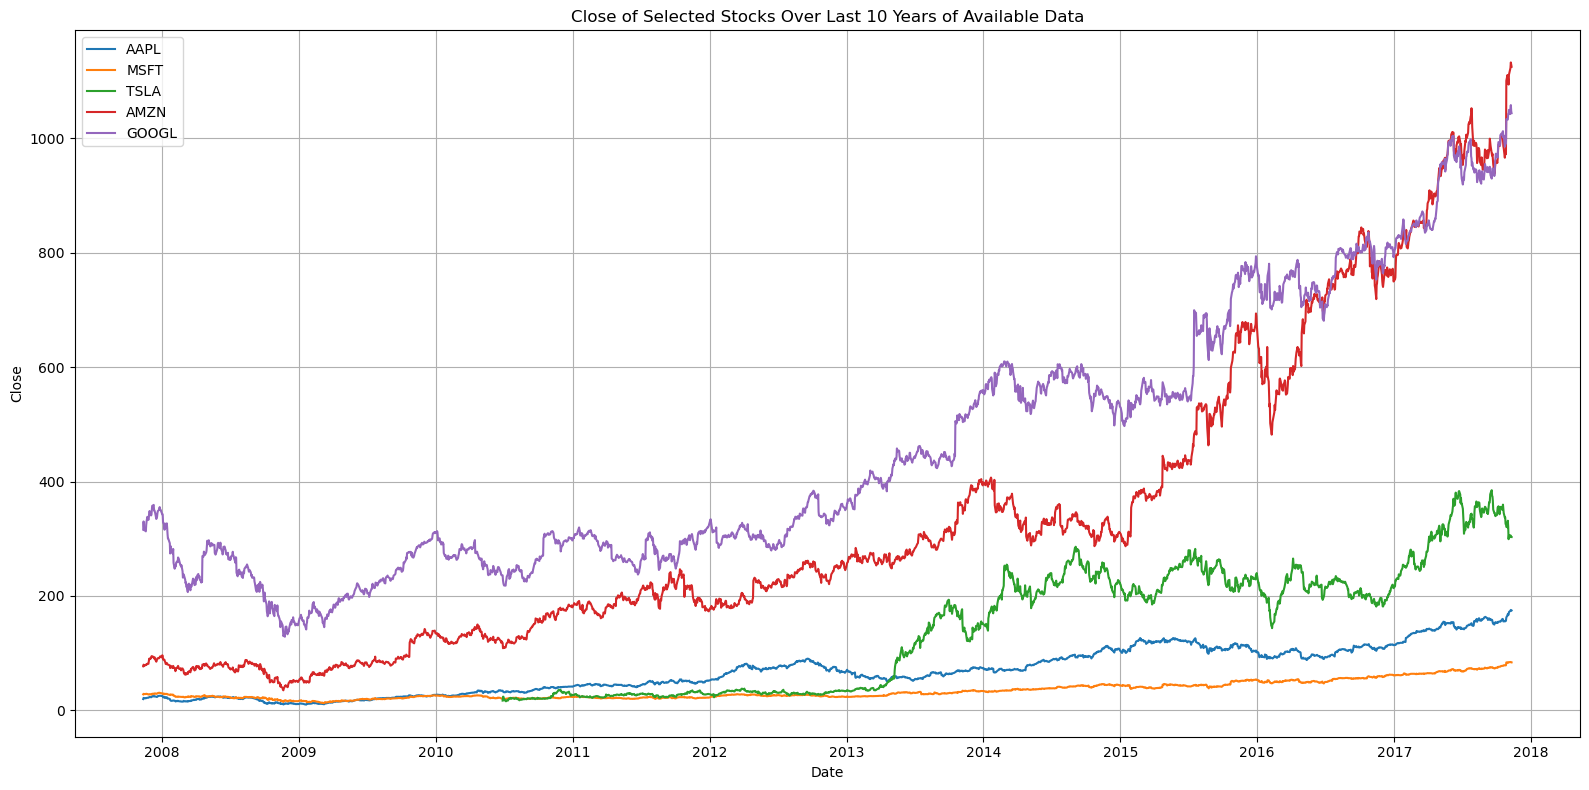

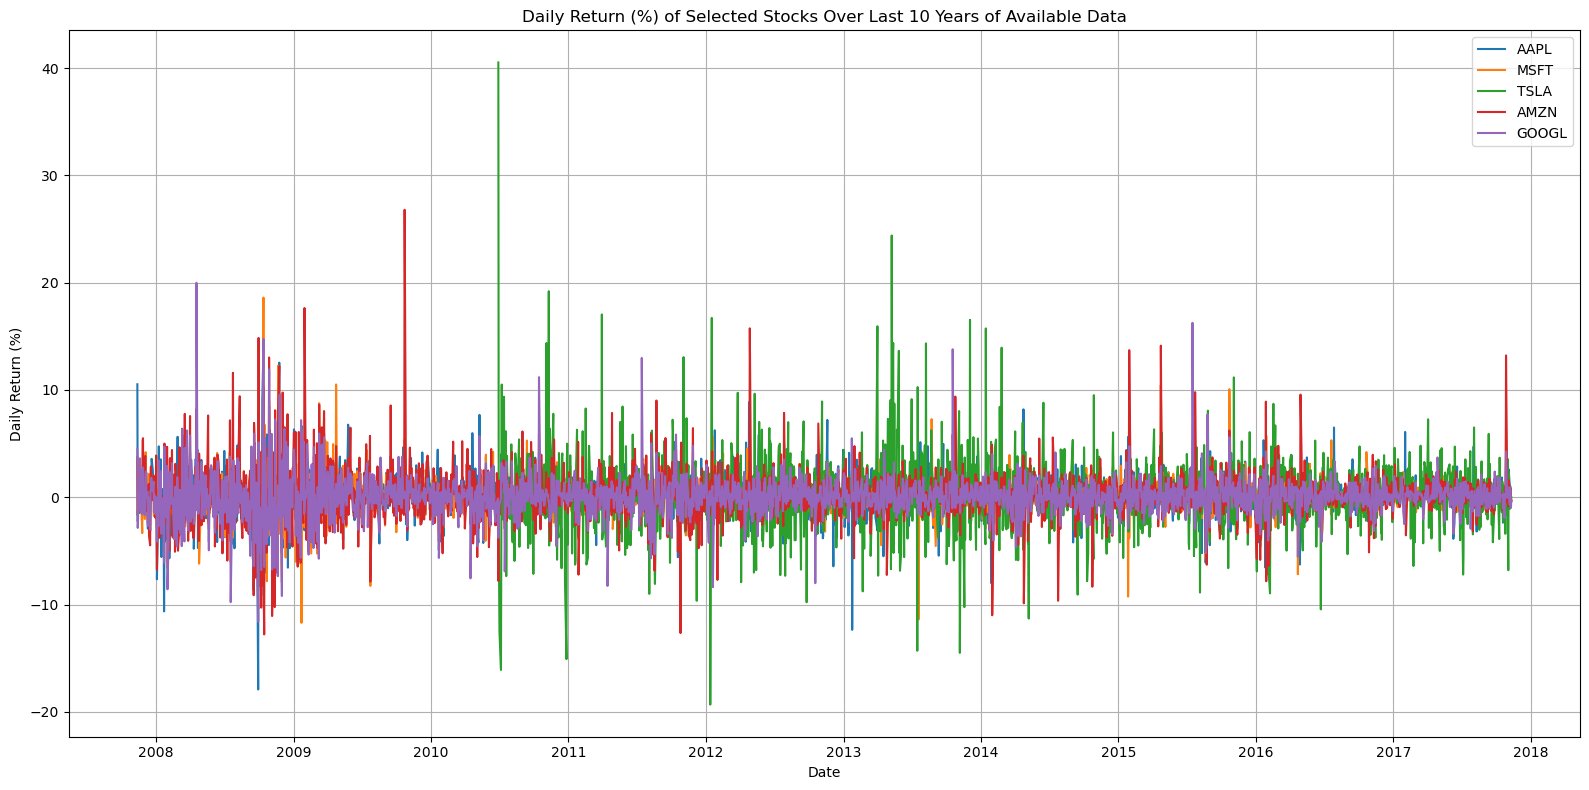

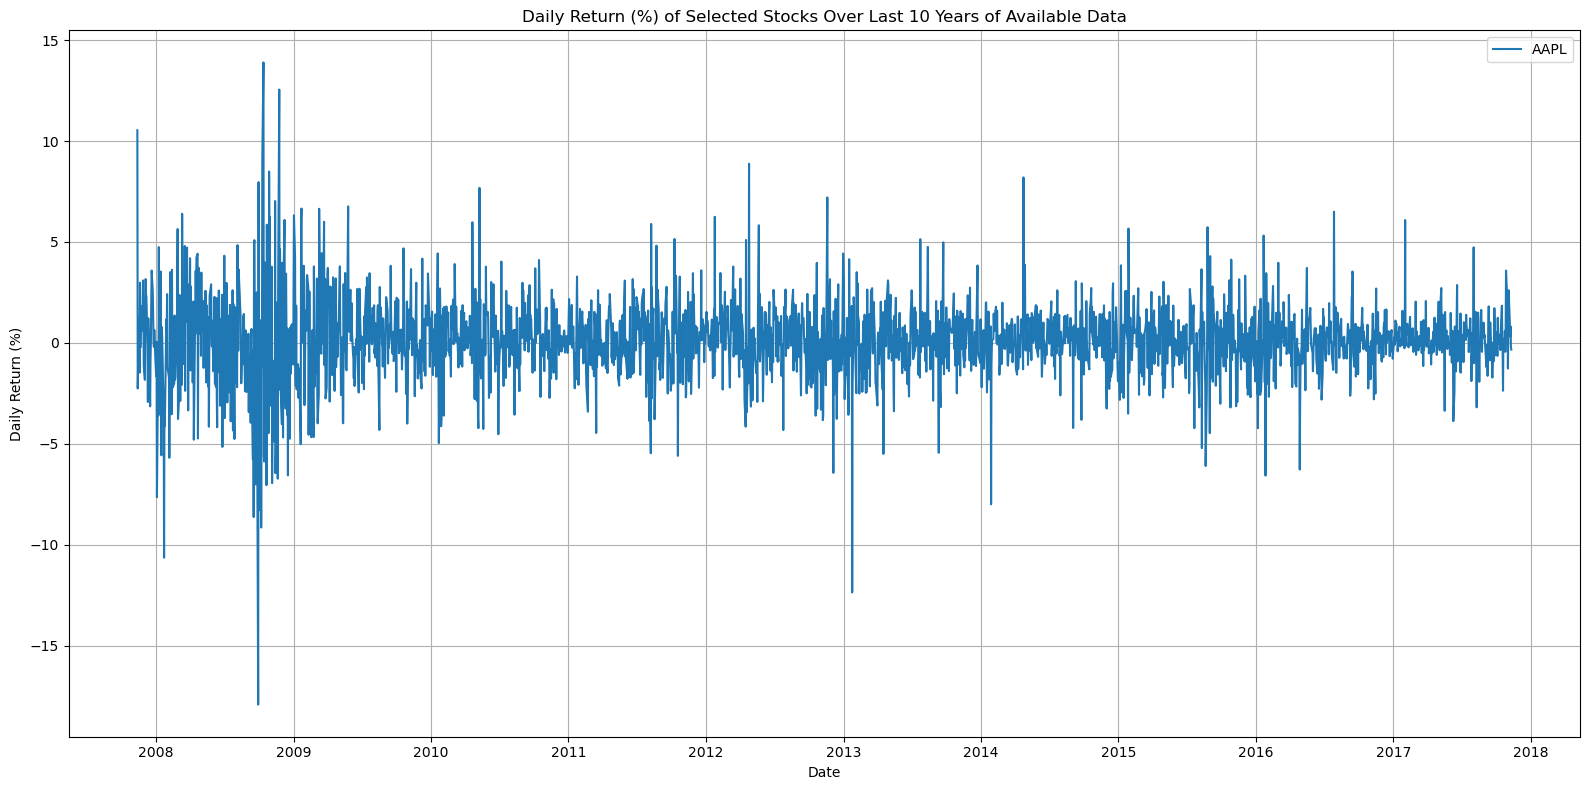

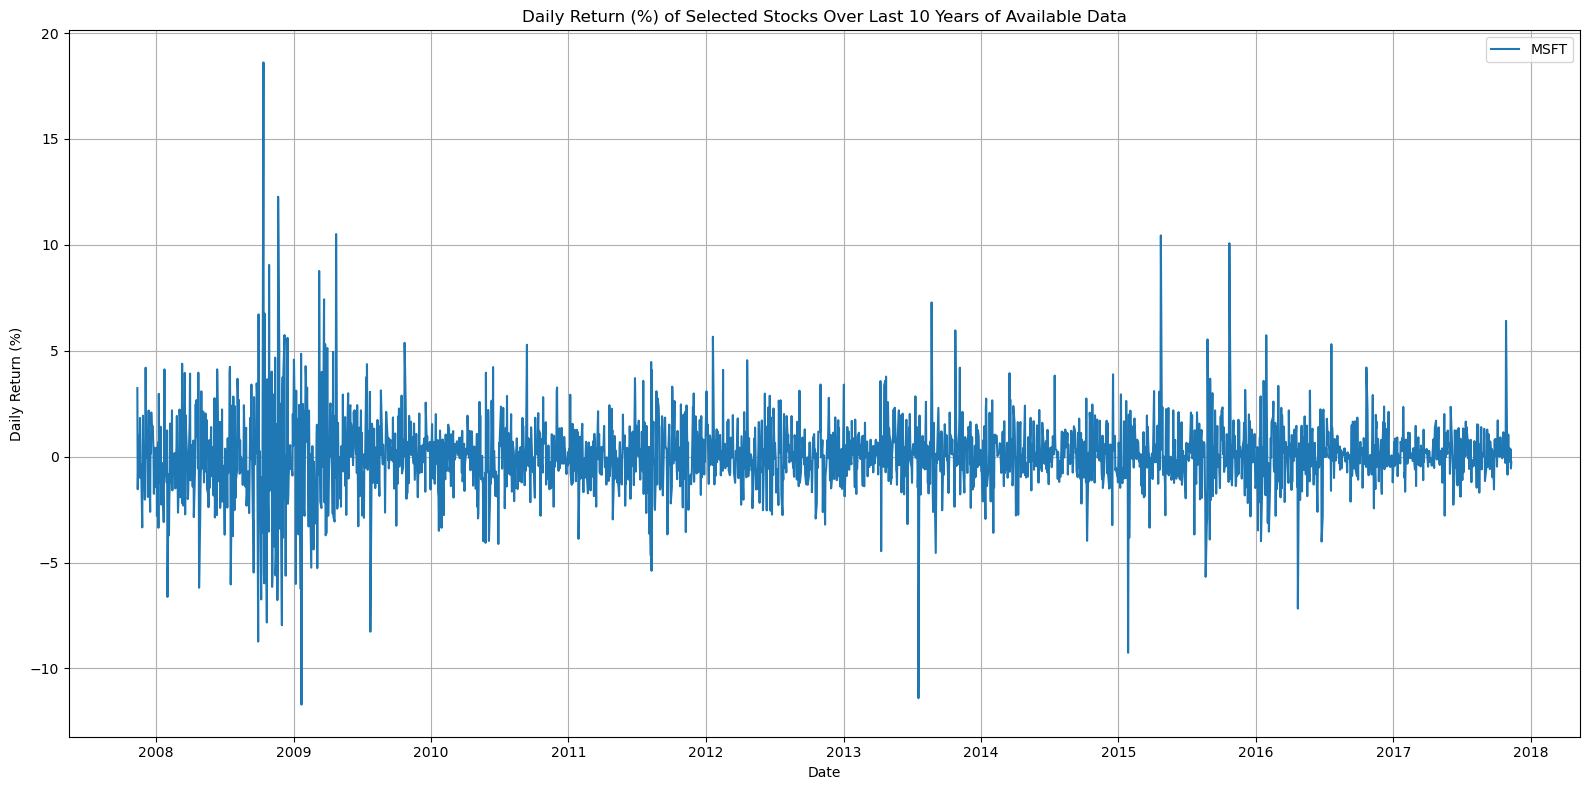

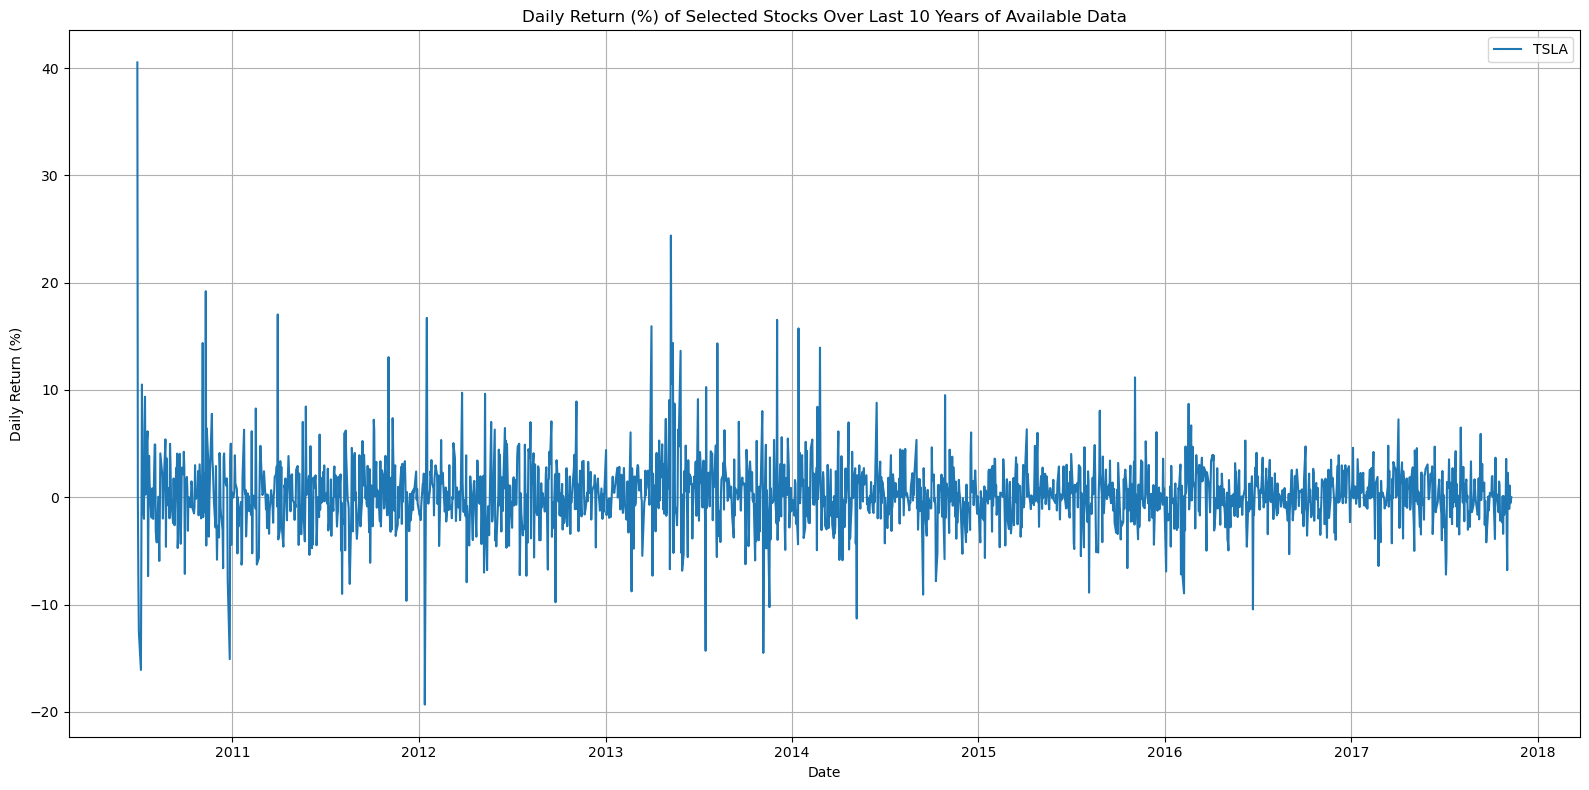

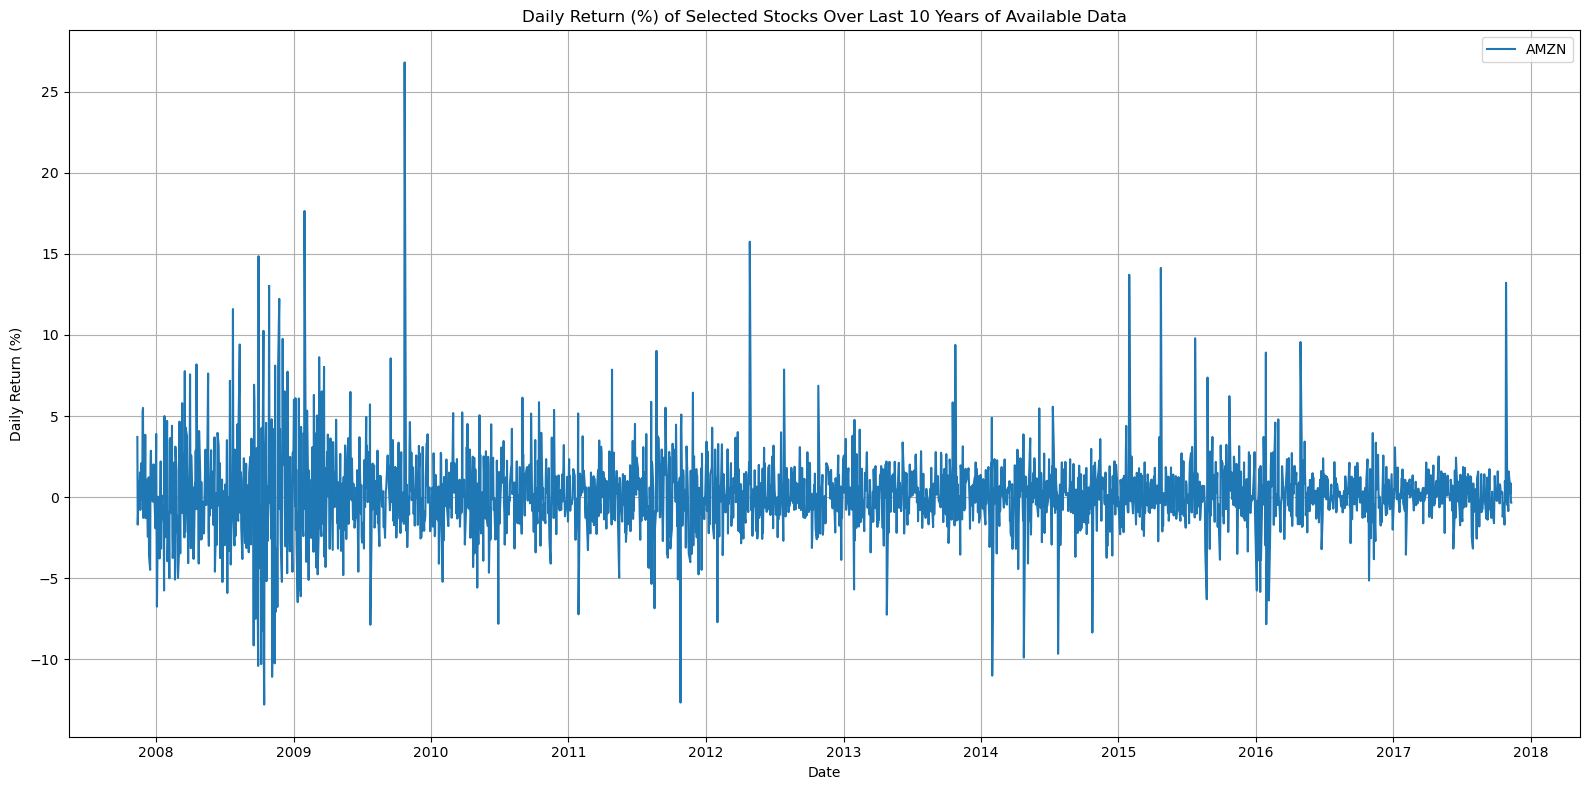

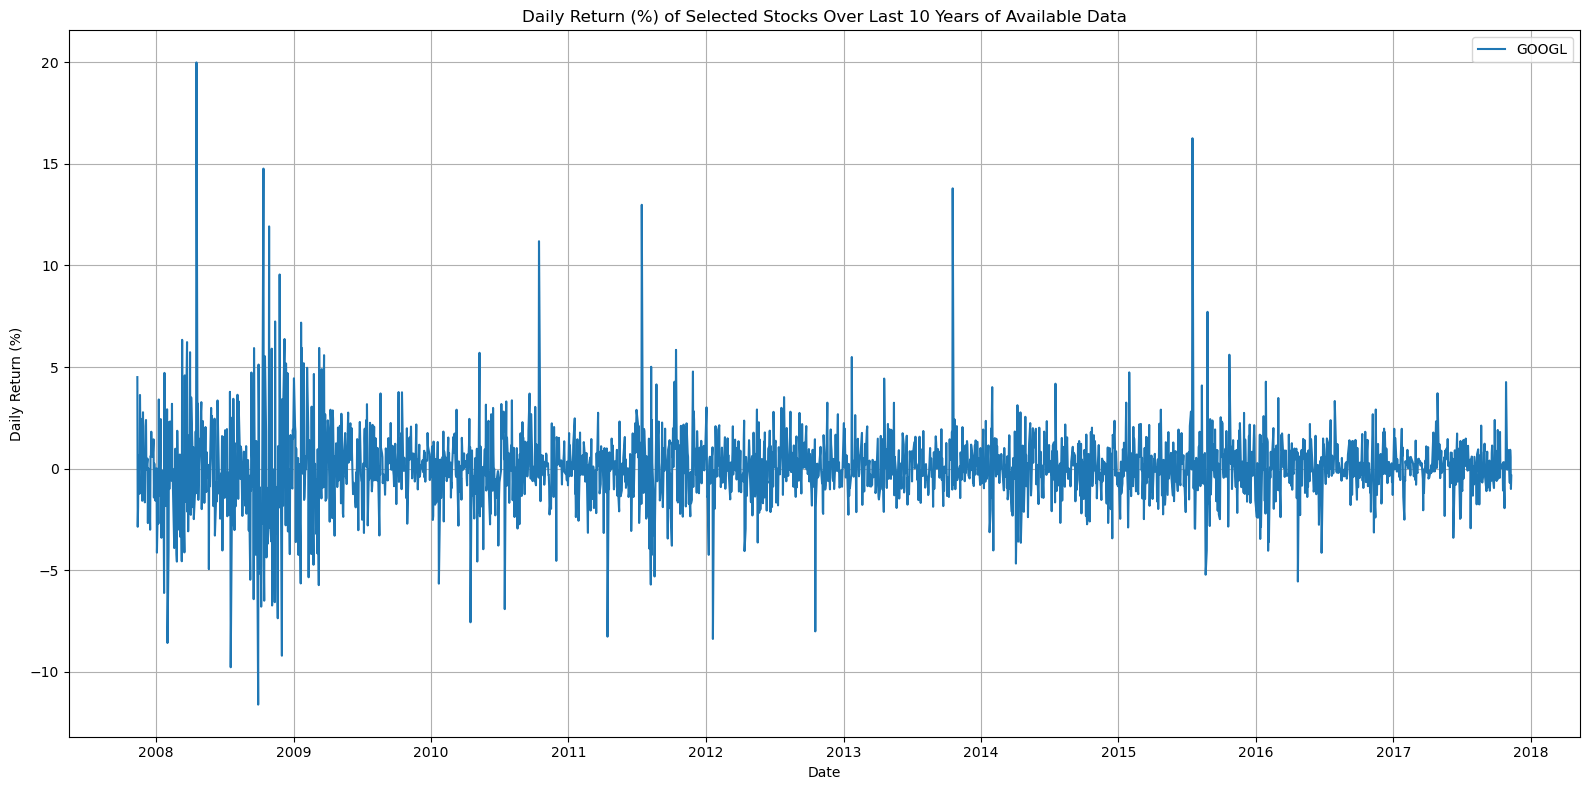

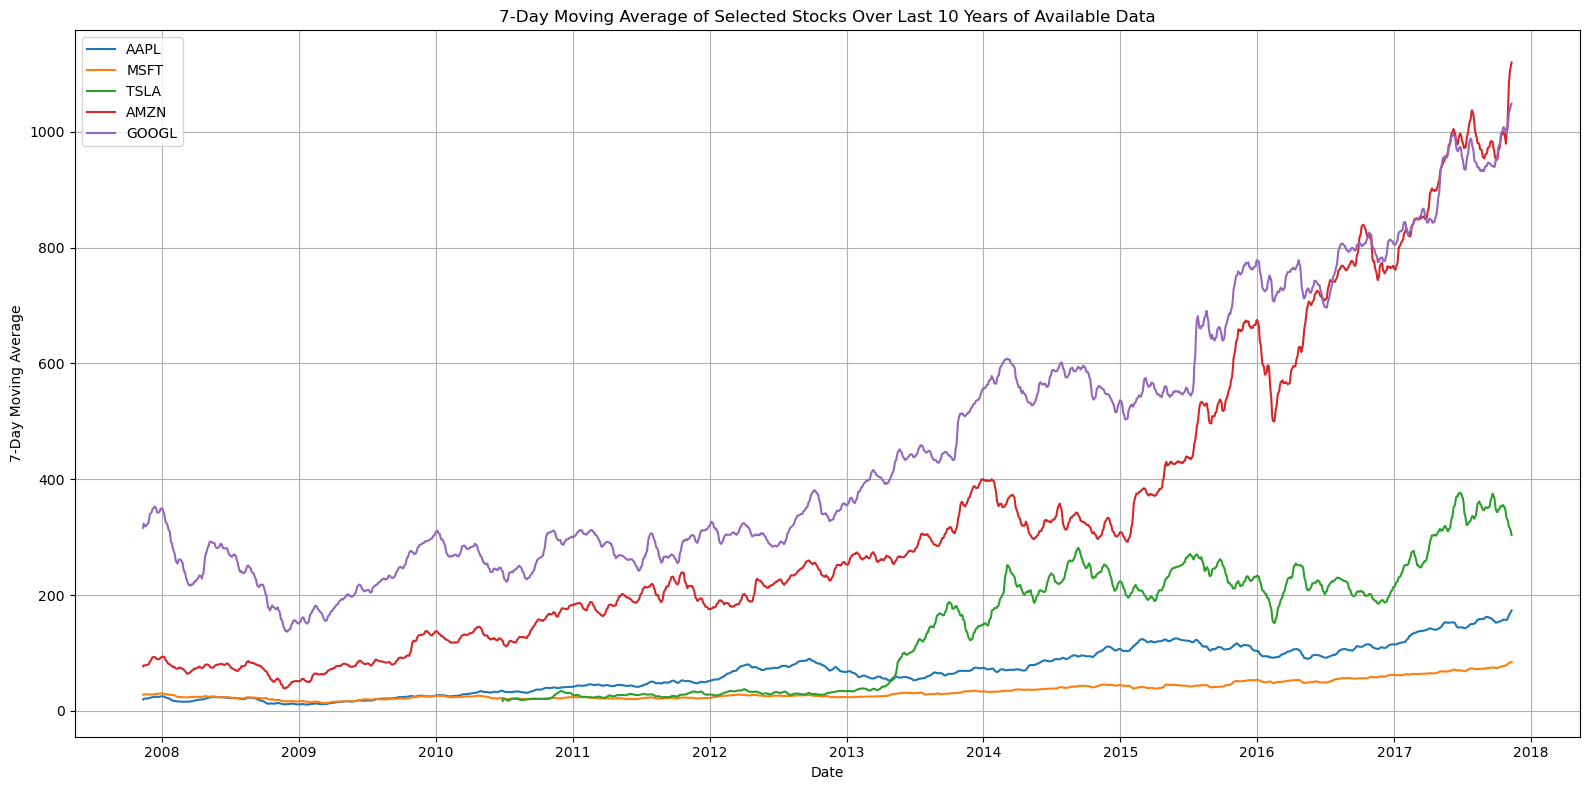

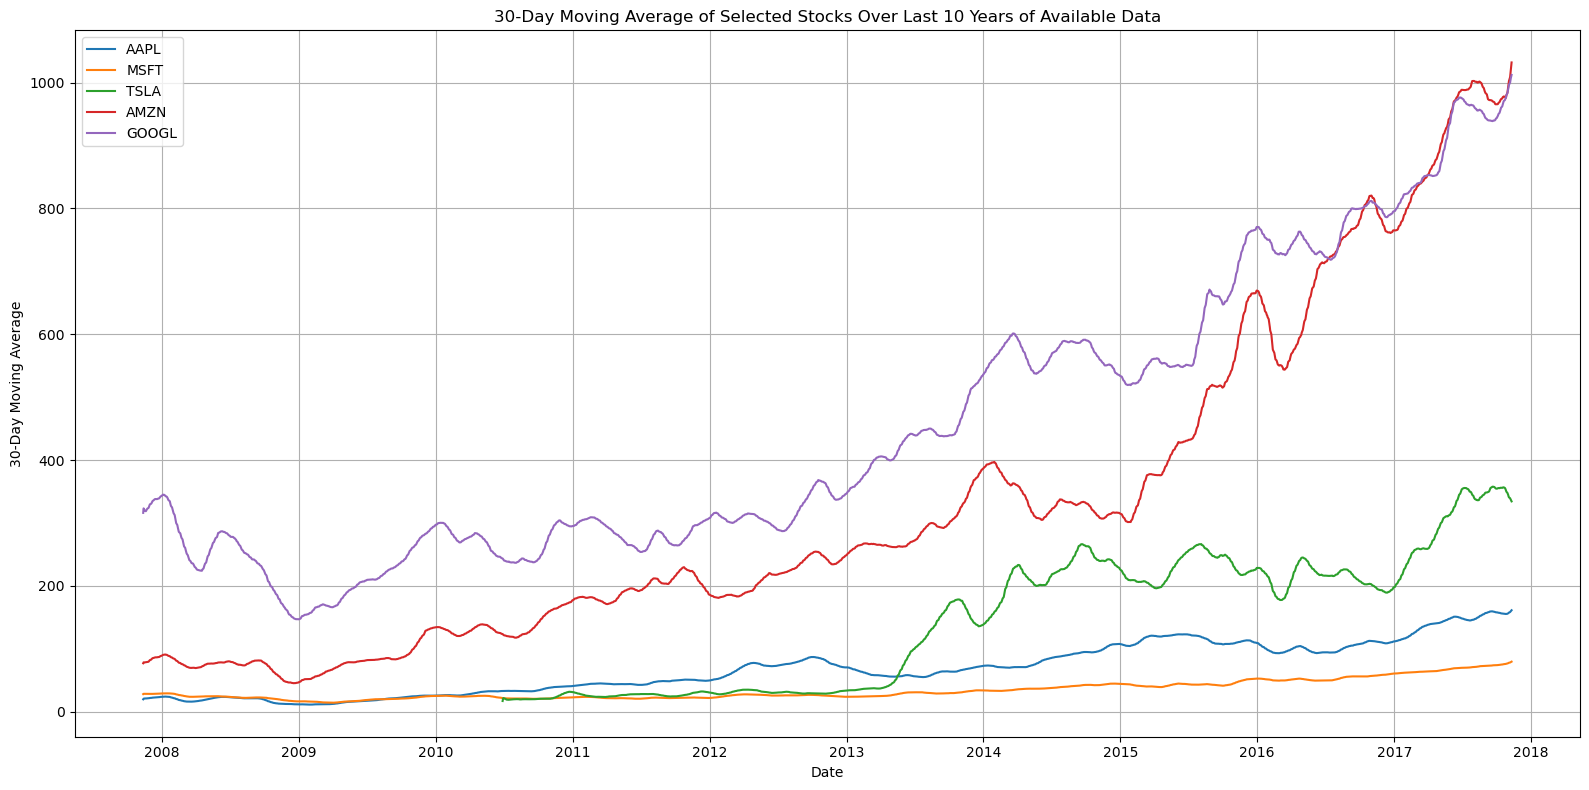

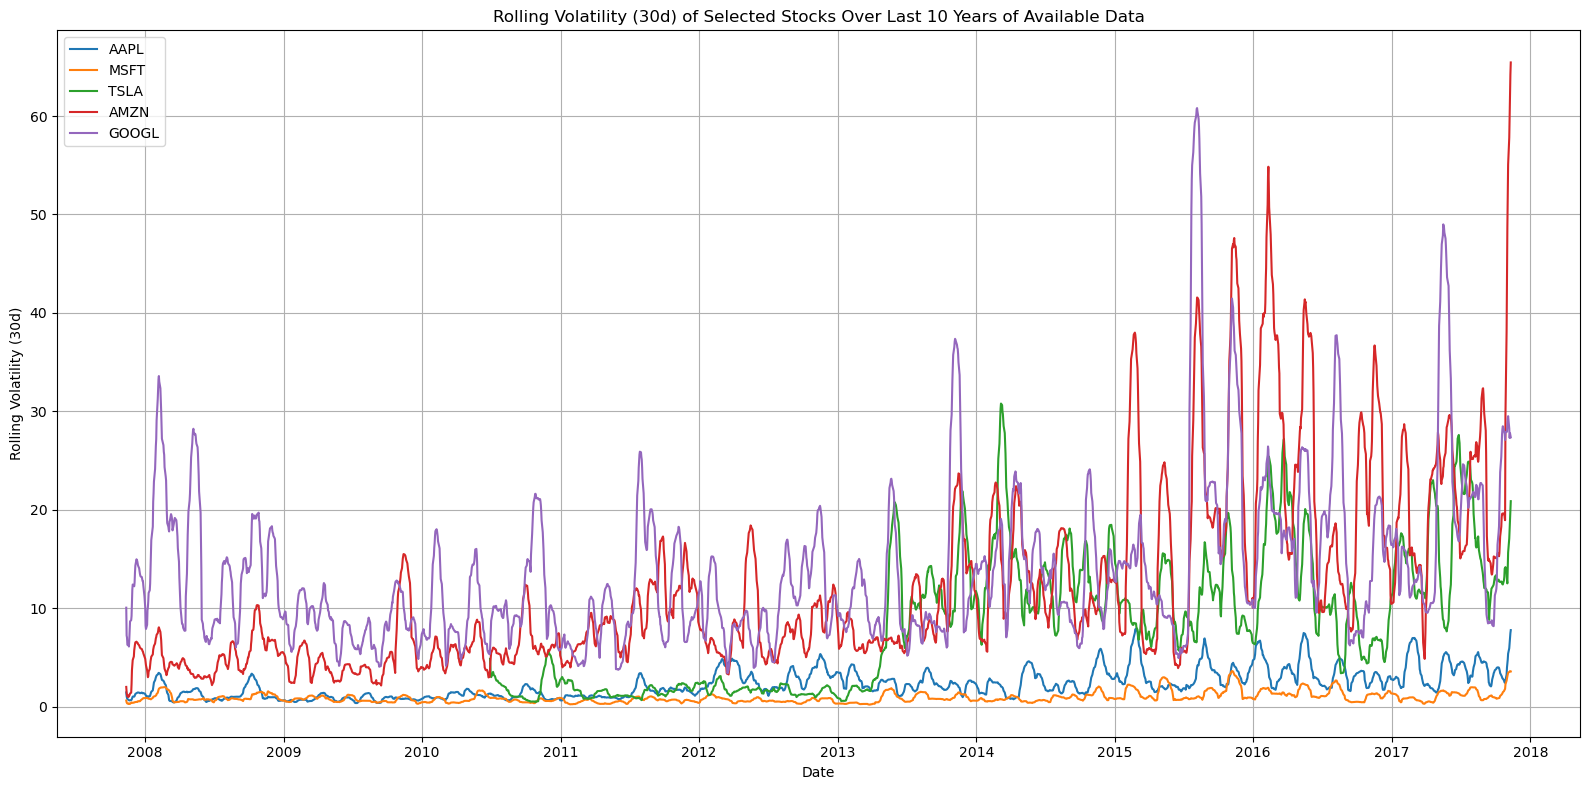

In [9]:
createPlot(tickers, "Close")

createPlot(tickers, "Daily Return (%)")
#daily return of some are hidden by others, so also plot individually
for ticker in tickers:
    createPlot([ticker], "Daily Return (%)")

createPlot(tickers, "7-Day Moving Average")

createPlot(tickers, "30-Day Moving Average")

createPlot(tickers, "Rolling Volatility (30d)")

# Week 2 


## Model Implementation and Evaluation
#### Choosing a stock - AMZN

In [10]:
stockTicker = "AMZN"
stockDF = dataFrames[stockTicker].copy(deep=True)

#### Splitting dataframe into training-80% and testing-20% datasets on the basis of date
- Only creating the index for the split as we still need to create features 

In [11]:
numberOfRows = stockDF.shape[0]
testDataStartIndex = (4*numberOfRows//5)


### Linear Regression Model
#### Creating past 5 day close value features for each row


In [34]:
def pastCloseFeature(noOfLaggingDays, df):
    for i in range(1,1+days):
        df[f"Lag{i}"] = df["Close"].shift(i)
    return df
days= 5
stockDF = pastCloseFeature(days, stockDF)


- Removing rows with NA values
- Setting features and target as X and y

In [16]:
stockDF.dropna(inplace = True)
#realigning the index for training and test data split
testDataStartIndex -= days
X = stockDF[[f"Lag{i}" for i in range(1,1+days)]]
y = stockDF["Close"]

#### Separating training and test data

In [17]:
def splitData(X, y):
    XTrain = X.iloc[:testDataStartIndex]
    yTrain = y.iloc[:testDataStartIndex]
    XTest = X.iloc[testDataStartIndex:]
    yTest = y.iloc[testDataStartIndex:]
    return (XTrain, yTrain, XTest, yTest)
(XTrain, yTrain, XTest, yTest)= splitData(X,y)

#### Model Implementation : Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics  import mean_absolute_error

linearRegressionModel = LinearRegression()
linearRegressionModel.fit(XTrain, yTrain)
yPred = linearRegressionModel.predict(XTest)

##### Visualising the prediction wrt to the true values

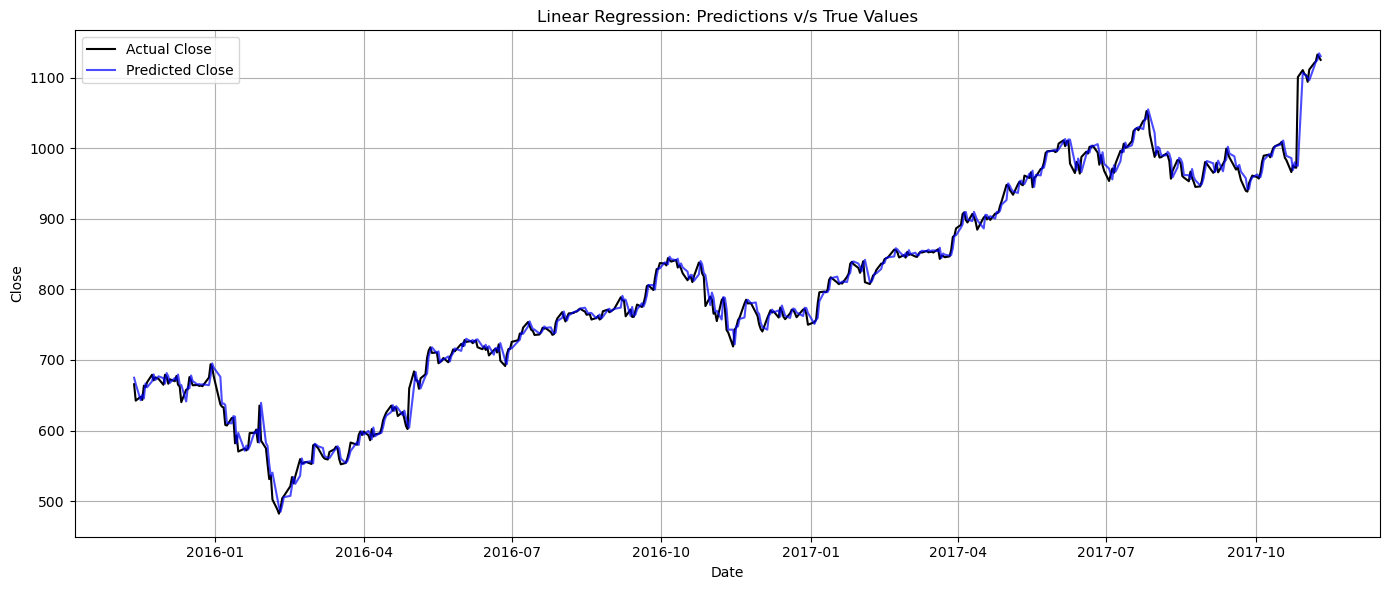

In [19]:
def createPredictionsPlot(predictions, true, parameter, title):
    plt.figure(figsize=(14, 6))
    plt.plot(true.index.get_level_values('Date'), true.values, label=f'Actual {parameter}', color='black')
    plt.plot(true.index.get_level_values('Date'), predictions, label=f'Predicted {parameter}', color='blue', alpha=0.7)
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(parameter)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
createPredictionsPlot(yPred, yTest, "Close", "Linear Regression: Predictions v/s True Values")

#### MAE and Directional Accuracy

In [20]:
def mae(predictions, true, title):
    mae = mean_absolute_error(true, predictions)
    print(f"MAE: {title} - {mae}")
    return mae
def directionAccuracy(predictions, true, title):
    correctDirection = np.sign(true.values[1:] - true.values[:-1]) == np.sign(predictions[1:] - true.values[:-1])
    directionalAccuracy = correctDirection.sum() / len(correctDirection) * 100
    print(f"Directional Accuracy: {title} - {directionalAccuracy}%")
    return directionalAccuracy
mae(yPred, yTest, "Linear Regression")
directionAccuracy(yPred, yTest, "Linear Regression")

MAE: Linear Regression - 8.180497299520173
Directional Accuracy: Linear Regression - 55.666003976143145%


55.666003976143145

### ARIMA Model
- Using statsmodel and converting stockDF to a series with date as index

In [21]:
from statsmodels.tsa.arima.model import ARIMA

def getDateSeries(df, parameter, stockTicker):
    return df.loc[stockTicker,parameter]
stockSeries = getDateSeries(stockDF, 'Close', stockTicker)

- Splitting data into training and testing data

In [22]:
#realigning test data start index ## only use if linear regression used before this
testDataStartIndex+=days
trainSeries = stockSeries[:testDataStartIndex]

#setting freq of date as business days
trainSeries= trainSeries.asfreq('B')
testSeries = stockSeries[testDataStartIndex:]

testSeries = testSeries.asfreq('B')

trainSeries = trainSeries.dropna()
testSeries= testSeries.dropna()

###### Method 1
- Using only training data to get multistep forecasting recursively
###### Method 2
- Using real data uptil the last day to get one-step ahead forecasting


#### Method 1

#### Creating model and fitting the data
##### (p, d, q) 
- p is number of lagging components in the representation of prediction as function of past values
- d is number of differencing to make the mean constant
- q is the number of lagged components of error
##### Using autoArima to automatically get best values for p,d,q

In [23]:

from pmdarima import auto_arima
def getOptimumOrder(trainSeries):
    autoModel=auto_arima(trainSeries, seasonal=False, trace=True, suppress_warnings=True)
    optimumOrder=autoModel.order
    return optimumOrder
#optimumOrder= getOptimumOrder(trainSeries)
#to reduce runtime, we only use autoarima once and have optimum order as 5,2,0
optimumOrder = (5,2,0)
def fitARIMAModel(optimumOrder):
    
    arimaModel = ARIMA(trainSeries,  order=optimumOrder) 
    fittedModel = arimaModel.fit()
    return fittedModel


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


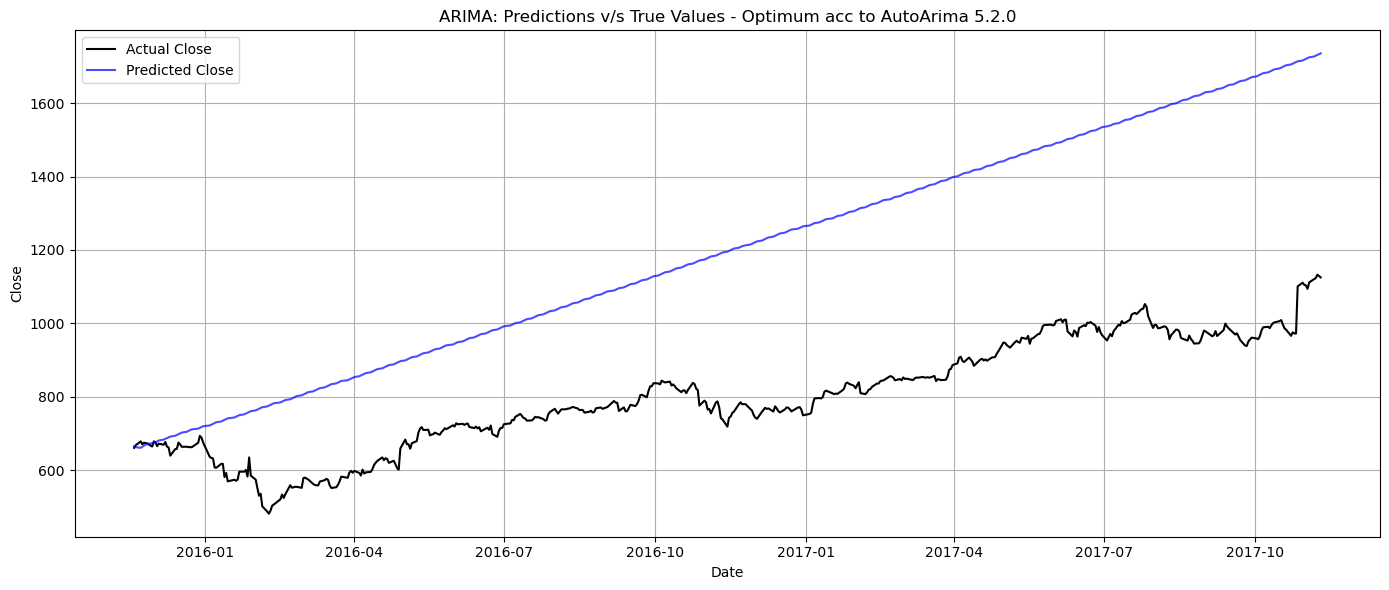

MAE: ARIMA: Optimum acc to AutoArima 5.2.0 - 395.40689642426725
Directional Accuracy: ARIMA: Optimum acc to AutoArima 5.2.0 - 55.020080321285135%


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


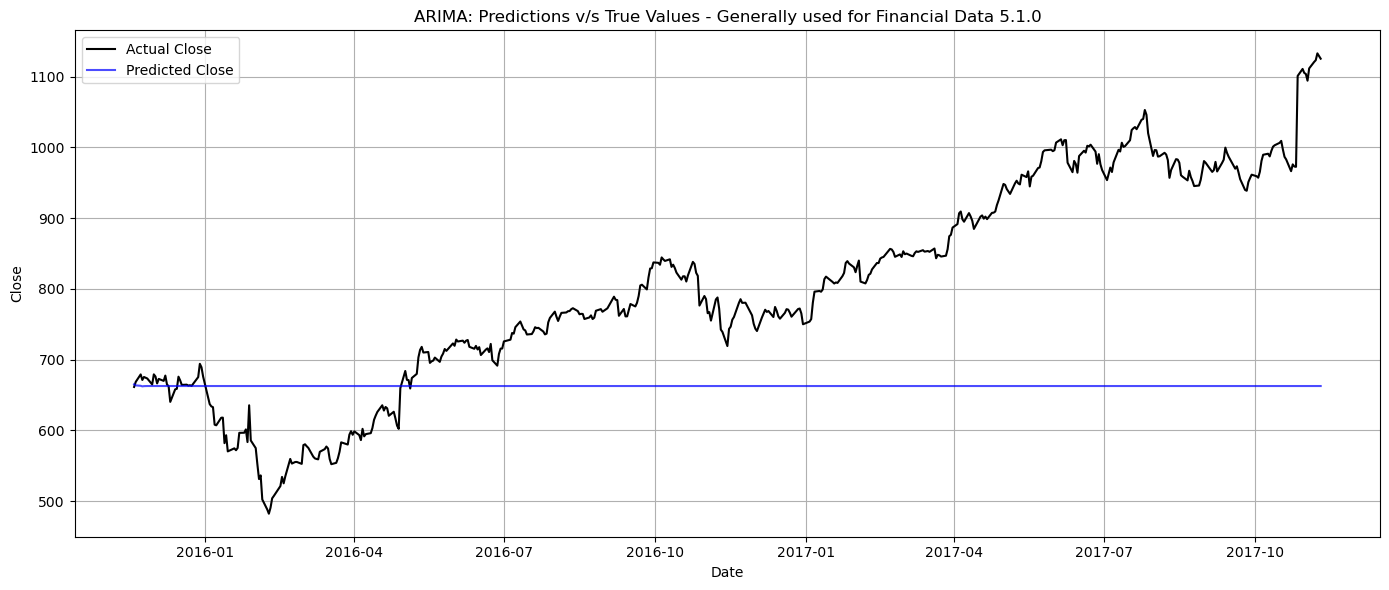

MAE: ARIMA: Generally used for Financial Data 5.1.0 - 167.19409204395774
Directional Accuracy: ARIMA: Generally used for Financial Data 5.1.0 - 47.18875502008032%


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\a

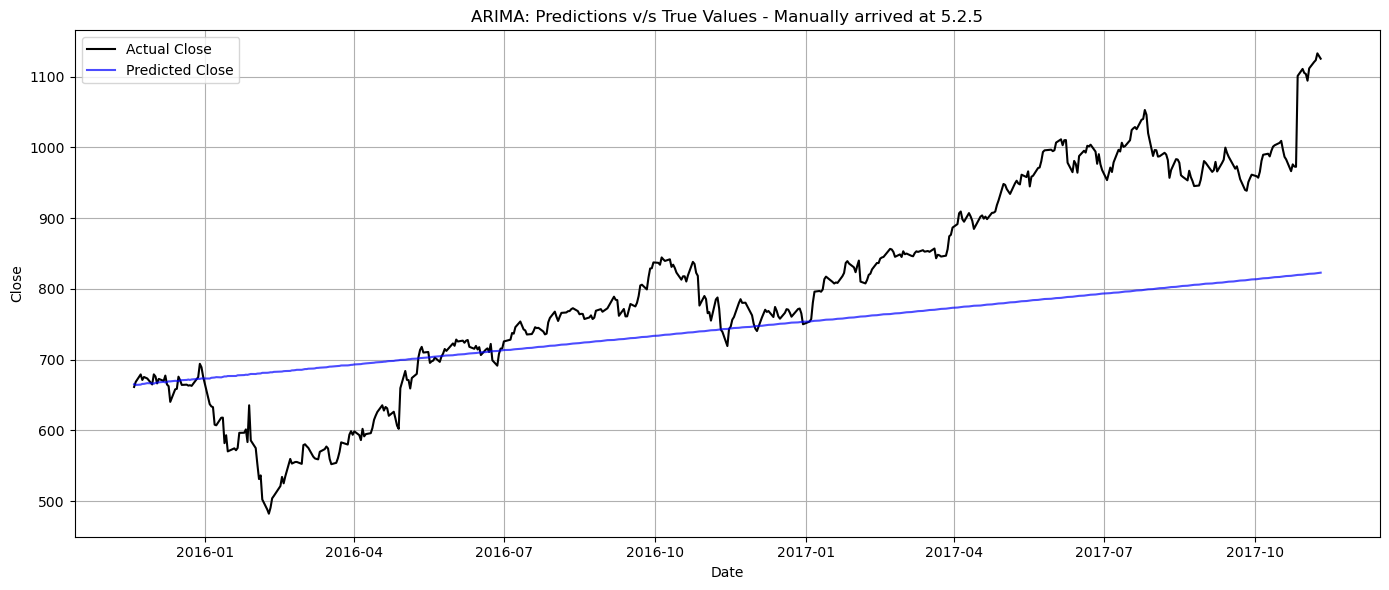

MAE: ARIMA: Manually arrived at 5.2.5 - 95.42198010913819
Directional Accuracy: ARIMA: Manually arrived at 5.2.5 - 48.99598393574297%


In [24]:
def createARIMAForecast(model, title):
    lenTest = len(testSeries)
    forecast = model.forecast(steps=lenTest)

    #Plotting
    createPredictionsPlot(forecast, testSeries, "Close", f"ARIMA: Predictions v/s True Values - {title}")
    return forecast
pdqs = [[(5,2,0),"Optimum acc to AutoArima 5.2.0"],[(5,1,0), "Generally used for Financial Data 5.1.0"], [(5,2,5),"Manually arrived at 5.2.5"]]
for pdq,title in pdqs:
    model = fitARIMAModel(pdq)
    forecast = createARIMAForecast(model, title)
    mae(forecast, testSeries, f"ARIMA: {title}")
    directionAccuracy(forecast, testSeries, f"ARIMA: {title}")

#### Method 2
- Since statsmodels ARIMA model does not allow updating the model, we have to retrain it to allow it use new data every day on a rolling basis
#### Note: Extremely Time Taking-  only uncomment last function call if want to run it 
- Set percent to the first nth part to predict, so if 1/10th of it is to be predicted set percent to 10

In [25]:
fullSeries =  pd.concat([trainSeries, testSeries])
percent = 10
def rollingARIMAModel(order):
    
    history = list(trainSeries)
    rollingPredictions=[]
    for t in range(len(testSeries)//percent):
        model = ARIMA(history, order=order)
        fittedModel = model.fit()
        prediction = fittedModel.forecast()[0]
    
        rollingPredictions.append(prediction)
        history.append(testSeries.iloc[t])
    return rollingPredictions
def callRollingModels(orders):
    for pdq,title in orders:
        modelPredictions = rollingARIMAModel(pdq)
        createPredictionsPlot(modelPredictions, testSeries.iloc[:len(testSeries)//percent] ,'Close',title)
        mae(modelPredictions, testSeries.iloc[:len(testSeries)//percent], f"ARIMA: {title}")
        directionAccuracy(modelPredictions, testSeries.iloc[:len(testSeries)//percent], f"ARIMA: {title}")
#callRollingModels([pdqs[0]])

#### Random Forest
##### RSI Calculation
- 14 day based RSI, using SMA, can also be done with EMA for smoothness


In [26]:
def computeRSI(series, window=14):
    #difference between t row  and t-1 row value
    delta = series.diff()

    gains = delta.clip(lower=0)
    losses = -delta.clip(upper=0) #absoulte value of losses

    avgGain = gains.rolling(window=window).mean()
    avgLoss = losses.rolling(window=window).mean()

    rs = avgGain/avgLoss
    rsi = 100 - (100/(1+rs))
    return rsi

- Taking new copy of stock dataframe to work with

In [27]:
rfdf = stockDF.copy(deep=True)
rfdf["RSI"] = computeRSI(rfdf['Close'], 14)

#also adding next day's close as what we want to predict
rfdf['Target'] = rfdf['Close'].shift(-1)

#top 13 would have NaN values so we drop them
rfdf = rfdf.dropna()

##### Splitting the data into training and testing datasets

In [28]:
Xrf= rfdf.drop(columns=['Target', 'Close']) # feature set
yrf = rfdf['Target']
(XTrain, yTrain, XTest, yTest) = splitData(Xrf, yrf)

#### Building Random Forest Model and Training

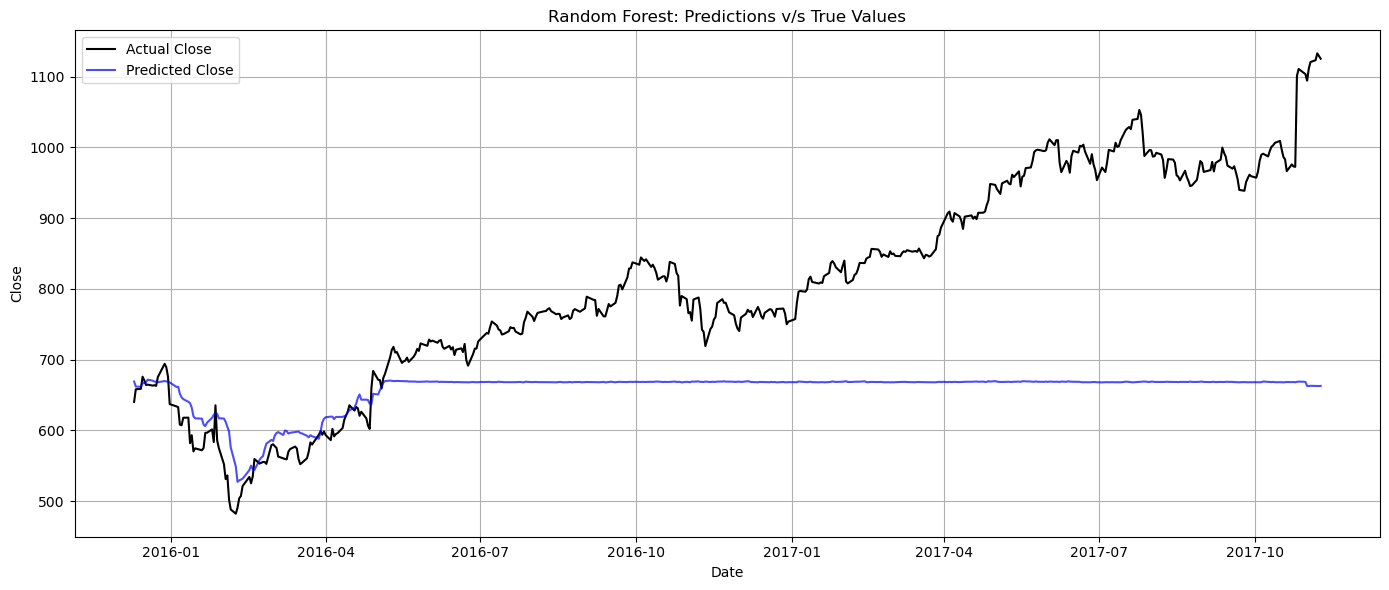

MAE: Random Forest - 158.16097685950396
Directional Accuracy: Random Forest - 47.4120082815735%


47.4120082815735

In [29]:
from sklearn.ensemble import RandomForestRegressor
#random_state is for reproducibility, i use 799 from my entry number
rf = RandomForestRegressor(n_estimators=100, random_state=799)
rf.fit(XTrain, yTrain)

yPred = rf.predict(XTest)

createPredictionsPlot(yPred, yTest, 'Close', "Random Forest: Predictions v/s True Values")

mae(yPred, yTest, "Random Forest")
directionAccuracy(yPred, yTest, "Random Forest")

- Due to reaching new high in stock price, the random forest errs and defaults to a constant value, as it is incapable of extrapolating data
- We can try to change this by making the features and target relative and not absolute on basis of price
      - We will use returns instead

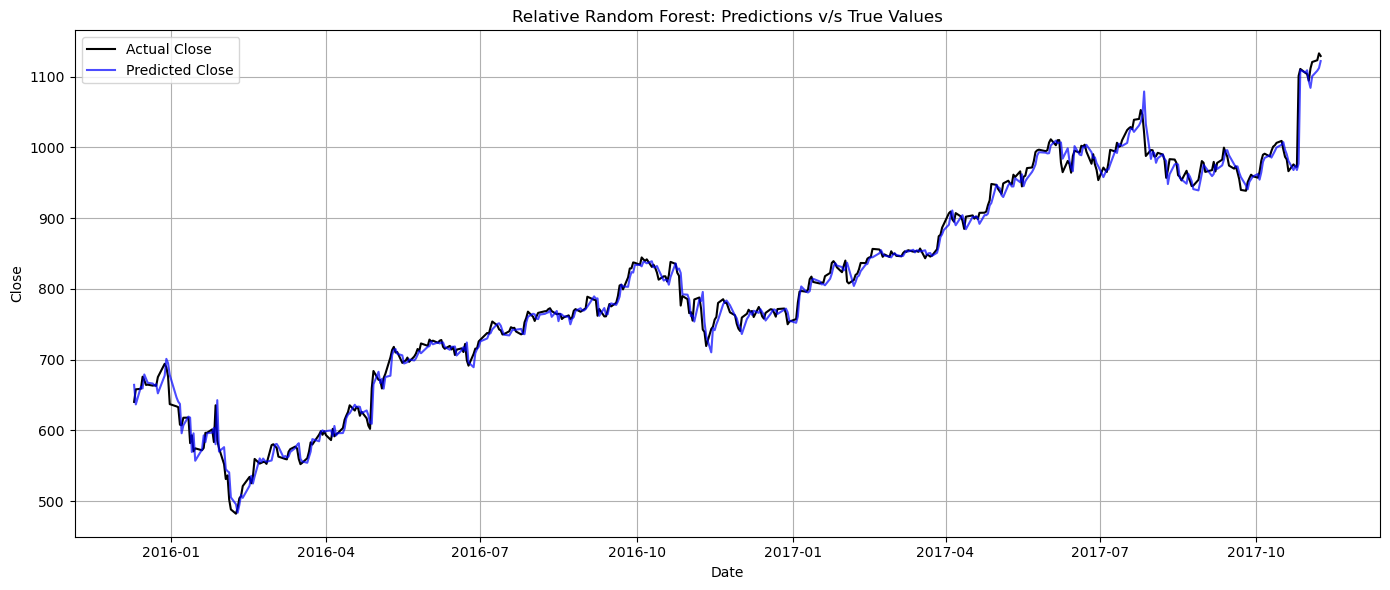

MAE: Relative Random Forest - 9.144151483215396
Directional Accuracy: Relative Random Forest - 47.9253112033195%


47.9253112033195

In [30]:
rfdf = stockDF.copy(deep=True)
rfdf["RSI"] = computeRSI(rfdf['Close'], 14)

#new target - return -next day's return based on today's close
rfdf['Return'] = rfdf['Close'].pct_change().shift(-1)


rfdf = rfdf.dropna()

Xrf= rfdf.drop(columns=['Return', 'Close']) # feature set
yrf = rfdf['Return']
(XTrain, yTrain, XTest, yTest) = splitData(Xrf, yrf)

#to recompute the prices we will store the actual closing prices and then use return pct and compute return price
actualClose =rfdf['Close'].iloc[testDataStartIndex:]


relativeRF = RandomForestRegressor(n_estimators=100, random_state=799)
relativeRF.fit(XTrain, yTrain)

relativeyPred = relativeRF.predict(XTest)

#back converting to prices
yTestPrice = actualClose.values[:-1] * (1 + yTest[:-1])
predictedPrice = actualClose.values[:-1] * (1 + relativeyPred[:-1])


createPredictionsPlot(predictedPrice, yTestPrice, 'Close', "Relative Random Forest: Predictions v/s True Values")

mae(predictedPrice, yTestPrice, "Relative Random Forest")
directionAccuracy(predictedPrice, yTestPrice, "Relative Random Forest")



- This results in much better MAE and slightly better Directional Accuracy

### Best Model - Linear Regression - Decent MAE and Best Directional Accuracy
#### To backtest we first make a buy or sell signal

In [52]:
days= 5
stockDF = pastCloseFeature(days, stockDF)
stockDF.dropna(inplace = True)
#realigning the index for training and test data split
testDataStartIndex -= days
X = stockDF[[f"Lag{i}" for i in range(1,1+days)]]
y = stockDF["Close"]
currentPrice = yTest.shift(1).values
(XTrain, yTrain, XTest, yTest)= splitData(X,y)
yPred = linearRegressionModel.predict(XTest)
signals = np.where(yPred > currentPrice , 1, 0)

AttributeError: 'numpy.ndarray' object has no attribute 'shift'

#### Simulating trading based on signals
- We buy when the signal is 1
- and we hold when the signal is 0 -  no return
- we sell at the end of the day- simplest backtest

In [53]:
# actual return = (next day's price - today's price) / today's price
actualReturns = (yTest.values - currentPrice) / currentPrice
actualReturns = np.nan_to_num(actualReturns, nan=0.0, posinf=0.0, neginf=0.0)
# strategy return = actual return * signal (i.e., 0 if not invested)
strategyReturns = actualReturns * signals

AttributeError: 'numpy.ndarray' object has no attribute 'values'

#### Now we simulate the portfolio
##### Assuming a intial capital of 1000 USD


In [54]:
iniCap = 1000
portfolio = [iniCap]

for ret in strategyReturns:
    newValue = portfolio[-1] * (1 + ret)
    portfolio.append(newValue)

# removing the first element to match lengths
portfolio = portfolio[1:]
print(portfolio[-1])

1644.211189799846


- To visualize the portfolio


In [60]:


plt.figure(figsize=(14,6))
plt.plot(yTest.index.get_level_values('Date'), portfolio, label='Strategy')
plt.title("Backtest: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 1400x600 with 0 Axes>